# Radience Data

In [57]:
import os.path
import glob
import matplotlib.pyplot as plt
import numpy as np

import iris
import iris.coords as coords
from iris import coord_systems
import iris.plot as iplt
import iris.quickplot as qplt
from iris.analysis import cartography
from iris.experimental.raster import export_geotiff

In [1]:
import rasterio

ModuleNotFoundError: No module named 'rasterio'

In [58]:
PATH = 'data/infrahack_irradiance/daily'
netcdf_filenames = glob.glob(os.path.join(PATH, '*.nc'))
netcdf_filenames.sort()
len(netcdf_filenames)

367

In [59]:
def load_irradiance(netcdf_filename):
    _, irradiance = iris.load_raw(filename)
    irradiance = irradiance[0]  # get rid of time dimension
    return irradiance


# BOUNDING_BOX
NORTH = 59
SOUTH = 48
EAST = 2
WEST = -10


def subset_to_uk(cube):
    constraint = iris.Constraint(
        coord_values={
            'latitude': lambda cell: SOUTH < cell < NORTH,
            'longitude': lambda cell: WEST < cell < EAST
        })
    return cube.extract(constraint)


def guess_bounds(cube):
    for coord in ['latitude', 'longitude']:
        cube.coord(coord).guess_bounds()
    return cube


def interpolate_to_linear_grid(cube):
    sample_points = [
        ('longitude', np.arange(start=WEST, stop=EAST, step=STEP)),
        ('latitude', np.arange(start=SOUTH, stop=NORTH, step=STEP))]

    return cube.interpolate(
        sample_points, 
        scheme=iris.analysis.Linear())


def plot_irradiance(cube, plot_contour=True):
    if plot_contour:
        qplt.contour(cube)
    else:
        qplt.pcolor(cube)
    ax = plt.gca()
    ax.coastlines()
    plt.show()
    return ax

In [60]:
_, irradiance = iris.load_raw(netcdf_filenames[0])
irradiance;

In [61]:
for filename in netcdf_filenames:
    print("Loading", filename)
    irradiance = load_irradiance(filename)
    irradiance = subset_to_uk(irradiance)
    zirradiance = interpolate_to_linear_grid(irradiance)
    irradiance = guess_bounds(irradiance)
    geotiff_filename = os.path.splitext(filename)[0] + '.geotiff'
    print("    Saving", geotiff_filename)
    export_geotiff(irradiance, geotiff_filename)

Loading data/infrahack_irradiance/daily/DNIdm201201010000002UD1000101UD.nc
    Saving data/infrahack_irradiance/daily/DNIdm201201010000002UD1000101UD.geotiff


ValueError: Coordinate 'longitude' bounds must be regularly spaced.

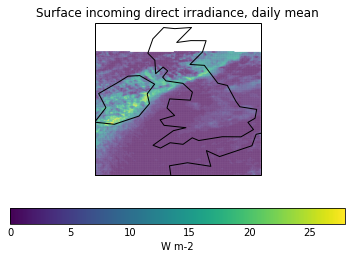

In [65]:
plot_irradiance(irradiance, plot_contour=False)

In [62]:
print(irradiance)

surface incoming direct irradiance, daily mean / (W m-2) (latitude: 219; longitude: 239)
     Dimension coordinates:
          latitude                                                x               -
          longitude                                               -               x
     Scalar coordinates:
          time: 2012-01-01 00:00:00
     Attributes:
          CDI: Climate Data Interface version 1.9.5 (http://mpimet.mpg.de/cdi)
          CDO: Climate Data Operators version 1.9.5 (http://mpimet.mpg.de/cdo)
          Conventions: CF-1.6
          DOI: 10.5676/EUM_SAF_CM/SARAH/V001
          history: Fri May 17 14:35:21 2019: cdo -v -L -f nc -r -sellonlatbox,-13.52002,2.70002,47.85998,61.71002...
          institution: EUMETSAT Satellite Application Facility on Climate Monitoring (CM SAF),...
          title: Surface Solar Radiation Data Set (SARAH)
